# Example of `darkmix` execution

Try to follow the `darkmix steps` document in the repository to make the code work in a basic way.

## Step 0 - Install necessary packages

If not already installed, install necessary packages, following the end of the README file

In [2]:
#install.packages(c("spatstat", "spatstat.utils", "LaplacesDemon", 
#                   "expint", "plotrix", "misc3d", "moments"))

## Step 1 - Setup

Load the necessary functions and packages.

In [3]:
source("../../Code/darkmix.R")
library(spatstat)
library(spatstat.utils)
library(expint)
library(plotrix)
library(misc3d)
library(LaplacesDemon)

Loading required package: spatstat.data
Loading required package: spatstat.geom
spatstat.geom 2.4-0
Loading required package: spatstat.random
spatstat.random 2.2-0
Loading required package: spatstat.core
Loading required package: nlme
Loading required package: rpart
spatstat.core 2.4-2
Loading required package: spatstat.linnet
spatstat.linnet 2.3-2

spatstat 2.3-4       (nickname: 'Watch this space') 
For an introduction to spatstat, type 'beginner' 


Attaching package: 'plotrix'

The following objects are masked from 'package:spatstat.geom':

    hexagon, rescale


Attaching package: 'LaplacesDemon'

The following object is masked from 'package:spatstat.random':

    is.stationary

The following object is masked from 'package:spatstat.geom':

    is.data



Read the data set to create the point process object and its quadrature:

In [4]:
data <- read.table("../../Data/datacat.txt")
minx <- 18; maxx <- 43; 
miny <- 171; maxy <- 196; 
minz <- 95; maxz <- 102;
clust <- pp3(x=data[,2],y=data[,3],z=data[,4], box3(xrange=c(minx,maxx), yrange=c(miny,maxy), zrange=c(minz,maxz)))
ntile <- c(50,50,14)
ntile <- c(100,100,28)
quad <- quad.3d(clust, ntile)

Declare a Finite Mixture Model of 10 cluster components plus background. Use Einasto profile for the clusters:

In [5]:
k <- 10
v <- 5
param2 <-c(k+1,rep(c(einasto.model,v),k), const.model,0)

## Step 2 - Initial guess

Initialize the parameters vector and generate an initial guess of the cluster centers:

In [6]:
param <- rep(0,k*(v+1))
cent <- centers(clust, h=0.3, ntile=c(25,25,7), k)
arg <- list(centers=cent[[1]], re=1, n=3, mix=1, back=-2)
param <- mixture.model(param, param2, output=c(), action.initial, arg)
param_df <- param2profile(param)

      x     y     z re n mix
1  33.5 178.5  99.5  1 3   0
2  36.5 192.5  98.5  1 3   1
3  39.5 174.5  97.5  1 3   1
4  25.5 189.5  98.5  1 3   1
5  20.5 192.5 100.5  1 3   1
6  38.5 193.5  96.5  1 3   1
7  37.5 175.5  99.5  1 3   1
8  33.5 172.5 100.5  1 3   1
9  32.5 185.5  99.5  1 3   1
10 21.5 190.5  98.5  1 3   1
Background mix: -2


The initial guess can be visualized:

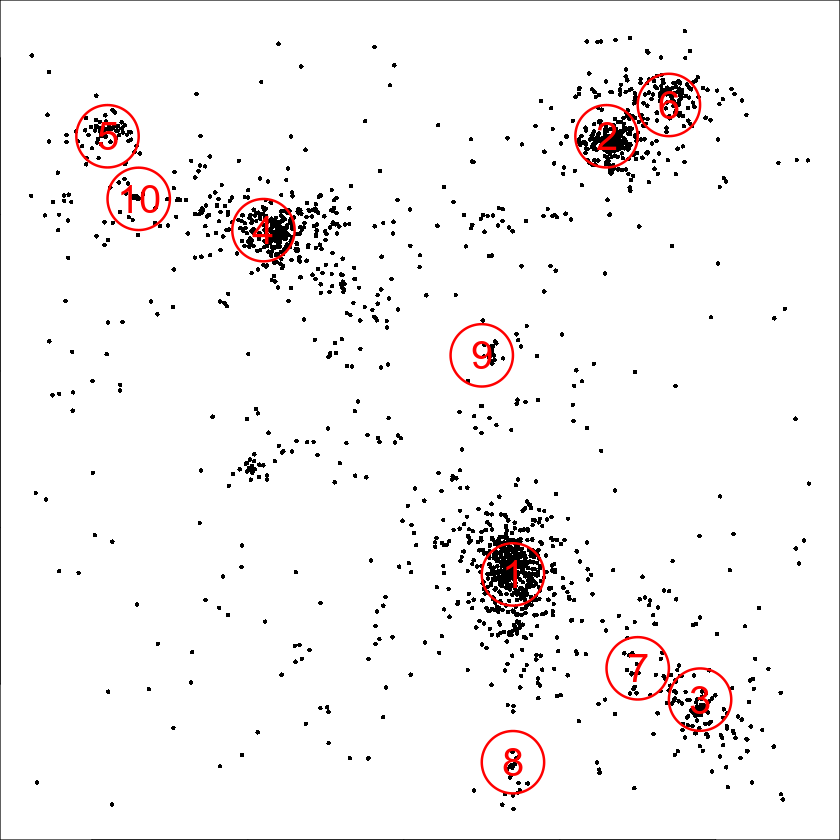

In [7]:
arg = list(mar=c(0,0,0,0), clust=clust, col=2, pch=16,border=2, cex=0.5, cexl=2, lwd=2)
out <- mixture.model(param, param2, output = NULL, action.draw, arg)

## Step 3 - Likelihood maximization

Optimize the parameters via Nelder-Mead algorithm. Save the result.

In [8]:
ocf <- optim(param, model.lik, param2=param2, model=mixture.model, clust=clust, quad=quad); 
param <- ocf$par

For further model refinement use the `mask.freeze` functions.

In [9]:
param <- mask.freeze(param, param2, mask.adjust_positions(k,v), clust, quad)
param <- mask.freeze(param, param2, mask.adjust_radii(k,v), clust, quad)
param <- mask.freeze(param, param2, mask.adjust_sersic(k,v), clust, quad)
param <- mask.freeze(param, param2, mask.adjust_mix(k,v), clust, quad)

The maximum likelihood, AIC and BIC can be calculated with

In [10]:
aic_bic <- AIC.BIC(param, param2, clust, quad)

[1] "Maximum log-likelihood: 1259.97151973845"
[1] "AIC: -2399.94303947691"
[1] "BIC: -2061.50680989329"


The resulting parameters are still far from the best fit. We would need to tepeat the previous steps to obtain better results. 
However, for now we just present the results for the fit we have done so far.

Visualize again to see the new model:

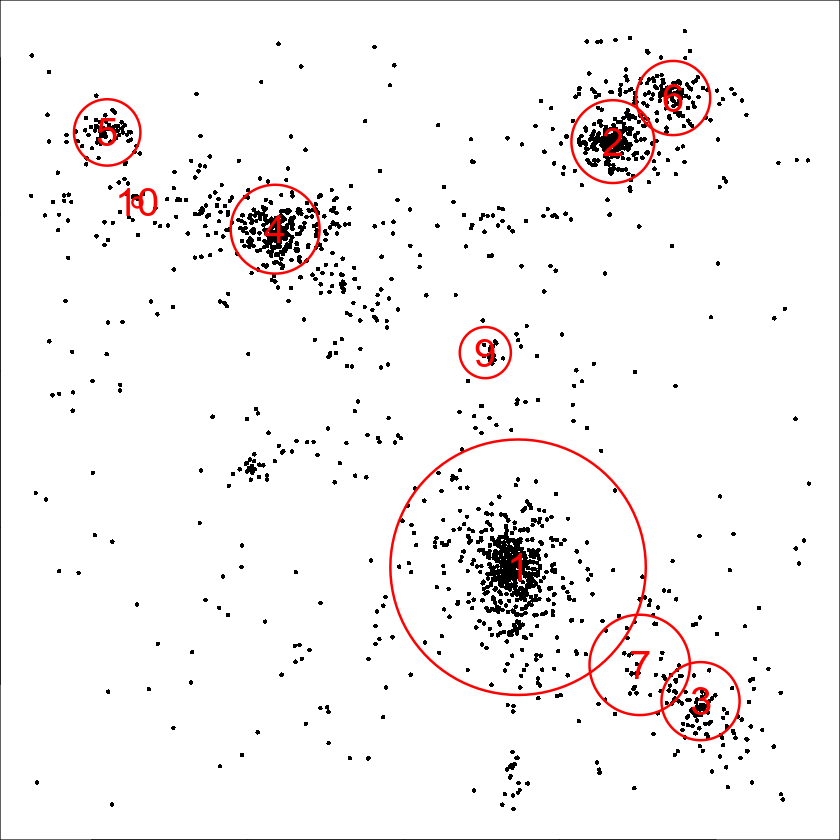

In [11]:
arg = list(mar=c(0,0,0,0), clust=clust, col=2, pch=16,border=2, cex=0.5, cexl=2, lwd=2)
out <- mixture.model(param, param2, output = NULL, action.draw,arg)

If the model is trusted, use it to estimate the number of particles per cluster:

In [12]:
arg <- list(clust=clust, quad=quad)
pop <- mixture.model(param,param2,output=c(), action.pop, arg)
pop

[1] 756.75799586 370.82659427 134.40499418 414.63596087  86.67630725
 [6] 116.64618730  14.27932726   0.00000000  34.88250702   0.08185145
[11] 151.80827454

## Step 4 - Goodnes of fit

The goodness of fit can be evaluated with function `goodness` (calculation might take several minutes).

In [14]:
setwd("../../")

In [15]:
goodness(param, param2, clust, quad, ntile, residual.type="raw", bandwidth=1)

[1] 0.9216401

The different kernel density fields can be generated at once. By order of appearance: absolute residuals, relative residuals, data density field and model density field.

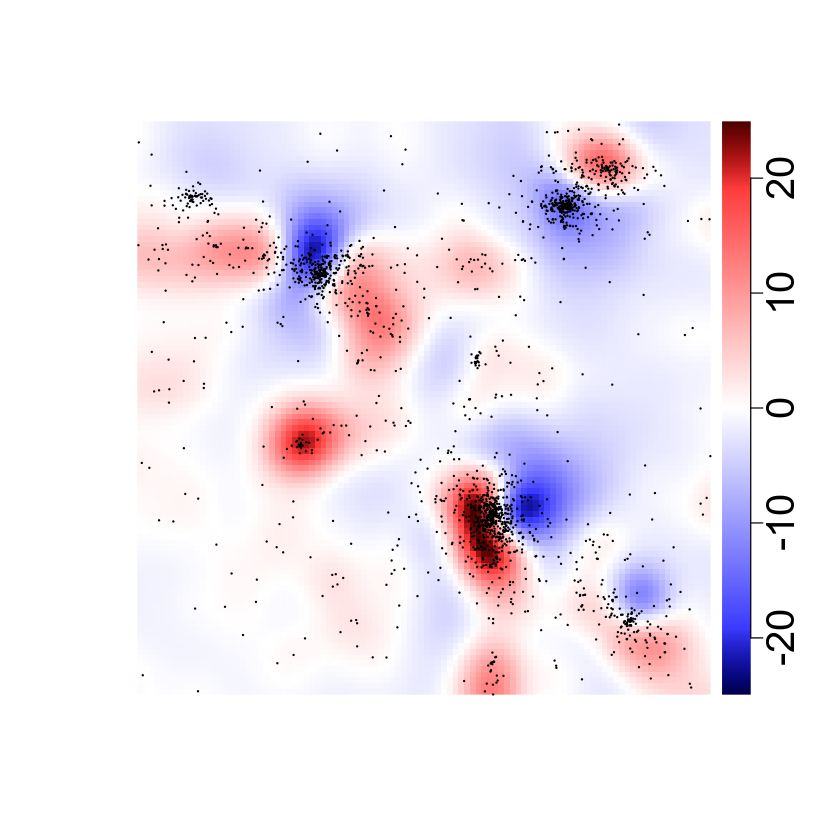

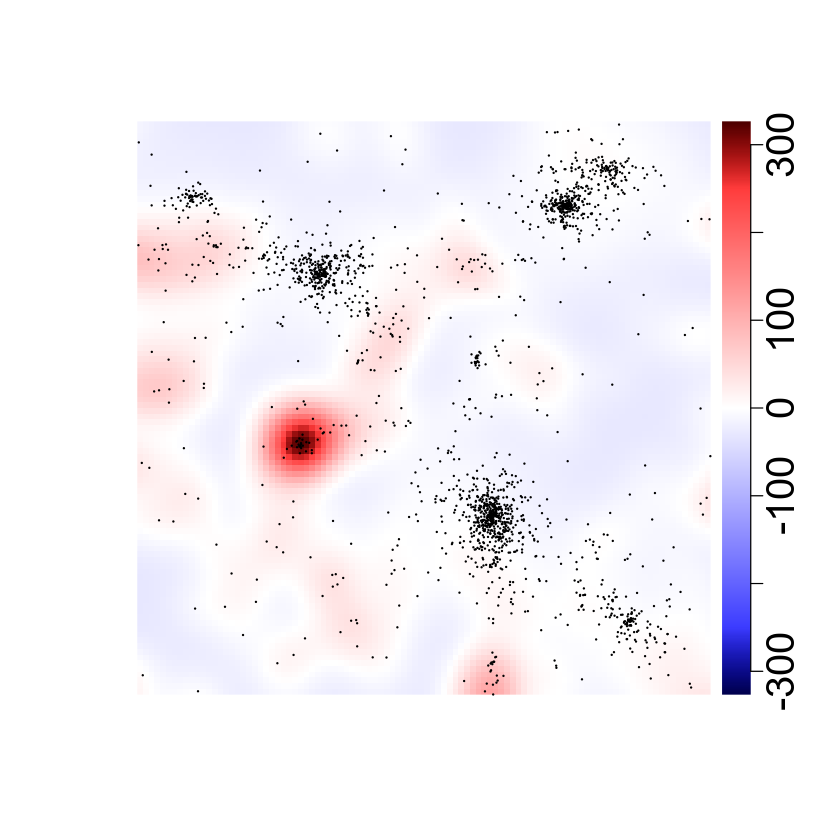

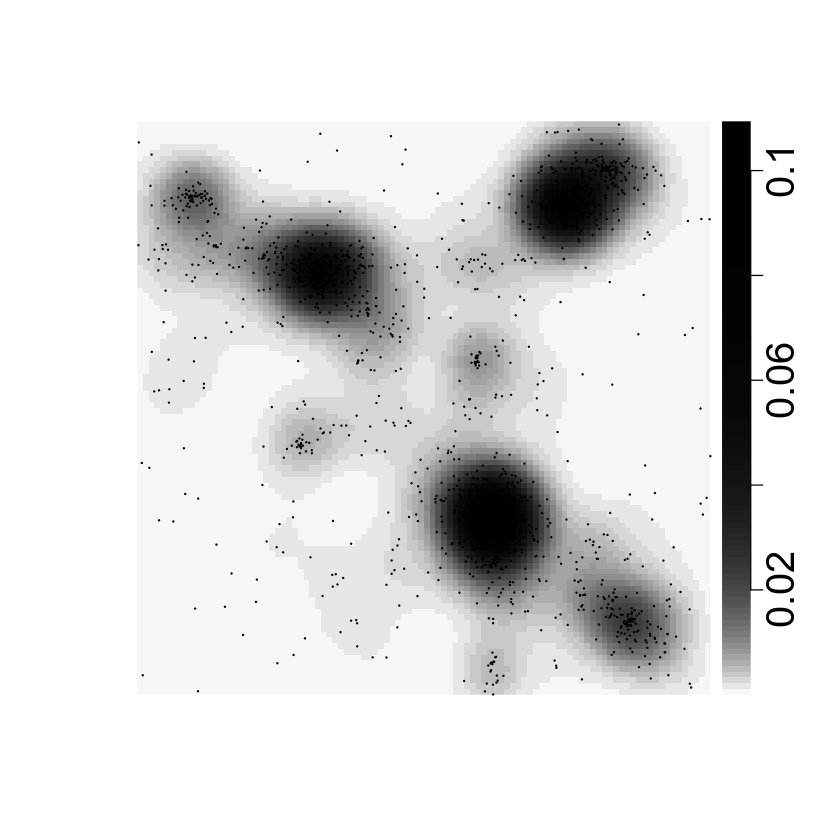

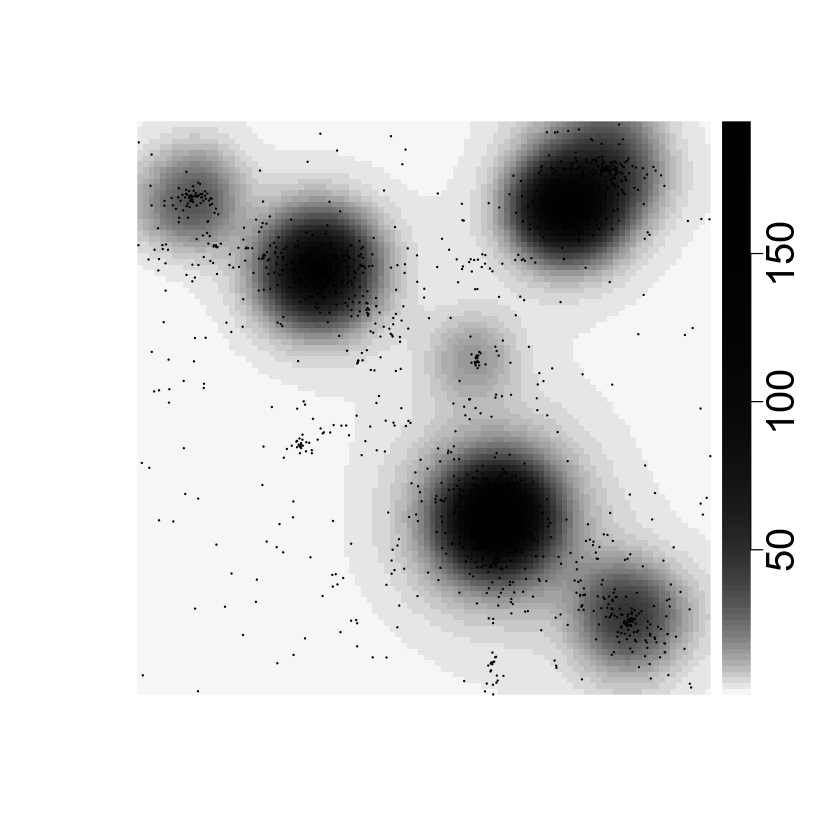

In [16]:
maps <- c("s", "e", "d", "m") 
plot.mm3d(param, param2, clust, quad, residual.type="raw", bandwidth=1, 
          maps=maps, fast=TRUE, col.point=1, scale="log", proj.var="Z", 
          print=FALSE, print.data=TRUE, w=880, h=880) 

The membership of each particle to the clusters can be obtained and plotted as follows:

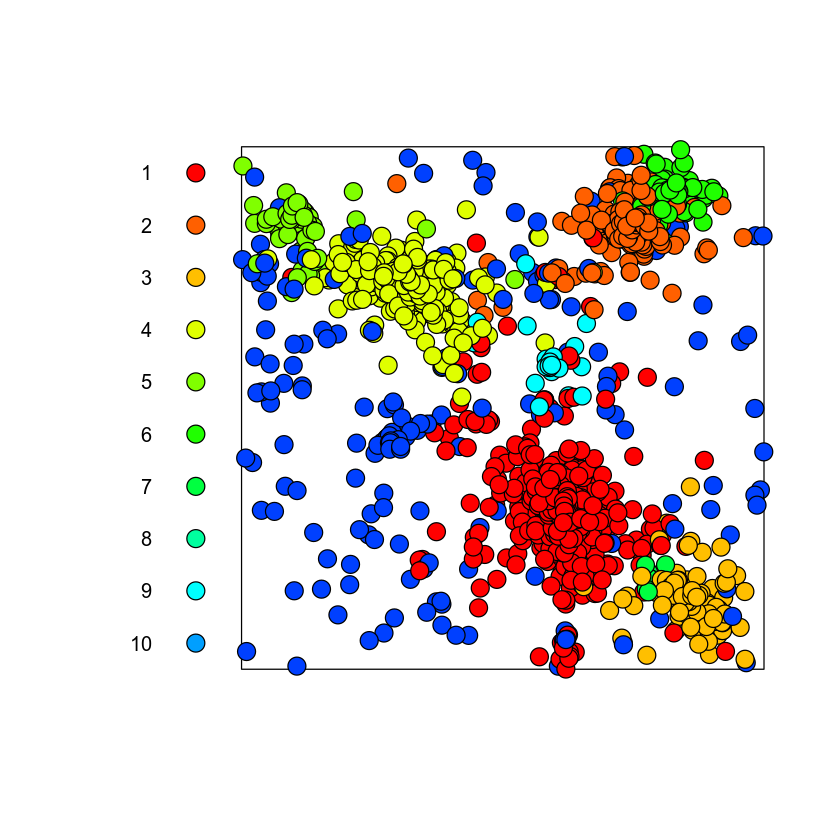

In [17]:
classification <- membership(param, param2, mixture.model, clust, threshold=0.3, print=FALSE)

Another possibility is to generate new samples reproducing the original data set (if a component has very few particles warnings might appear).

In [18]:
window <- clust$domain
num_particles <- data.frame(table(classification[[1]]$class))
data_generated <- gen.pattern(param, param2, num_particles, window, scl=4)

Warning message in max(which((epsi[j] > cum) == TRUE)):
"no non-missing arguments to max; returning -Inf"Warning message in max(which((epsi[j] > cum) == TRUE)):
"no non-missing arguments to max; returning -Inf"Warning message in max(which((epsi[j] > cum) == TRUE)):
"no non-missing arguments to max; returning -Inf"Warning message in max(which((epsi[j] > cum) == TRUE)):
"no non-missing arguments to max; returning -Inf"

Visualize the new sample with

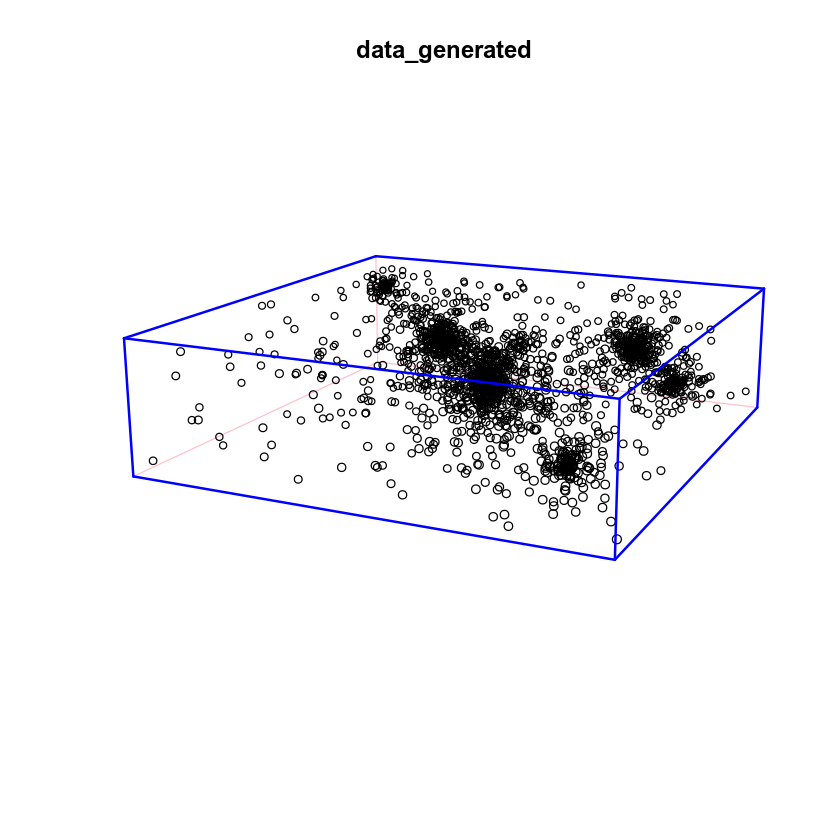

In [19]:
plot(data_generated)

We can visualize as well the empirical density profile as centered in a given component together with the full model and the single component estimations. For example, for component 4:

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"2 y values <= 0 omitted from logarithmic plot"

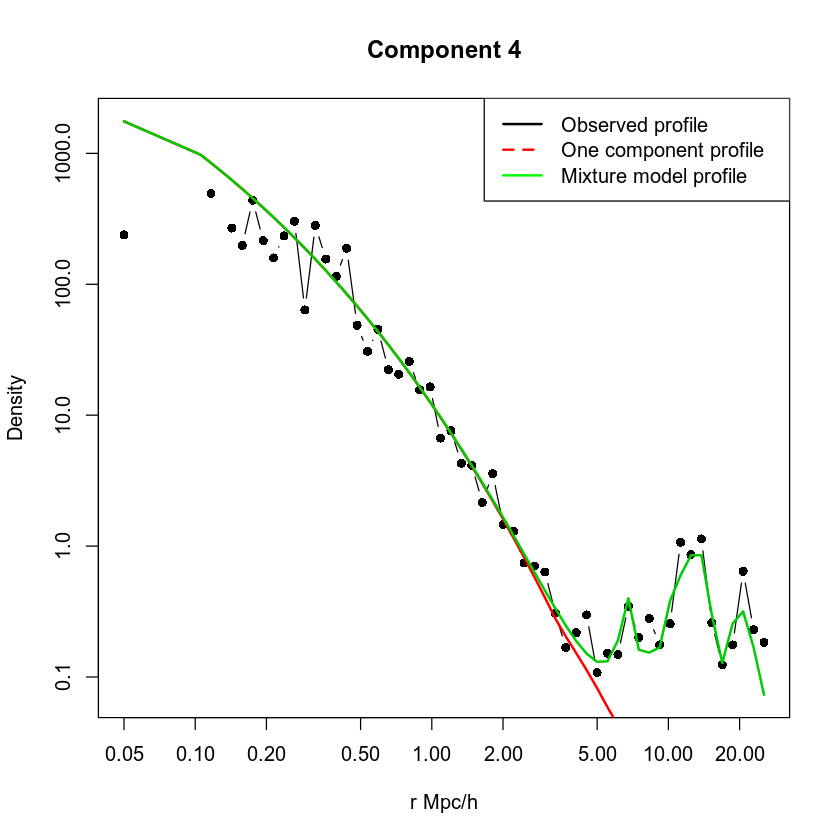

In [20]:
comp <- 4
profiles <- plot.profile(param, param2, clust, comp, xlim=c(0.1,40), nbin=60, flag.legend=TRUE)

## Step 5 - New model

Although we do not execute these functions here, we include the necessary calls for the MCMC routines:

In [21]:
MyData <- ready.mcmc(clust,quad,param2,rbord=0.5)
method="twalk"
Fit <- run.ld(param,MyData,method,iter=10000)
param <- Fit$Posterior2


Laplace's Demon was called on Wed Apr 13 18:12:55 2022

Performing initial checks...
[1] "Center of halo 8 is outside the window."
[1] "Halo 8 has negative S\303\251rsic index: -0.110868296827081"


ERROR: Error in LaplacesDemon(model.post, Data = MyData, Initial.Values, Covar = NULL, : SIV results in a non-finite posterior.TRUE
